In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import torch
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()

In [2]:
path = "/Users/abhishekpatnaik/Downloads/quora-question-pairs/train.csv"

In [3]:
df = pd.read_csv(path)

In [4]:
df.head(15)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [5]:
idx = 404286
print(df.question1.loc[idx],df.question2.loc[idx])

Do you believe there is life after death? Is it true that there is life after death?


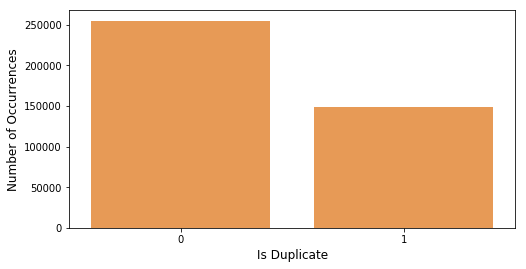

In [6]:
is_dup = df['is_duplicate'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.show()

In [7]:
# Now lets see how different questions looks like
diff = df[df['is_duplicate'] == 0]
diff = diff.reset_index()

In [8]:
diff.head()

,index,id,qid1,qid2,question1,question2,is_duplicate
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
idx = 10
print(diff.question1.loc[idx],diff.question2.loc[idx])

Why do girls want to be friends with the guy they reject? How do guys feel after rejecting a girl?


In [10]:
# the very first method that came to my mind was sentence similarity


In [11]:
from gensim.models import Word2Vec

In [12]:
tokenized_sentences1 = diff.question1.loc[10].split()
tokenized_sentences2 = diff.question2.loc[10].split()
model1 = Word2Vec(tokenized_sentences1,min_count=1)
model2 = Word2Vec(tokenized_sentences2,min_count=1)

In [13]:
tokenized_sentences1, tokenized_sentences2

(['Why',
  'do',
  'girls',
  'want',
  'to',
  'be',
  'friends',
  'with',
  'the',
  'guy',
  'they',
  'reject?'],
 ['How', 'do', 'guys', 'feel', 'after', 'rejecting', 'a', 'girl?'])

In [14]:
def get_cosine(vec1, vec2):
        intersection = set(vec1.keys()) & set(vec2.keys())
        numerator = sum([vec1[x] * vec2[x] for x in intersection])

        sum1 = sum([vec1[x]**2 for x in vec1.keys()])
        sum2 = sum([vec2[x]**2 for x in vec2.keys()])
        denominator = math.sqrt(sum1) * math.sqrt(sum2)

        if not denominator:
            return 0.0
        else:
            return float(numerator) / denominator

def review_to_wordlist(review, remove_stopwords=False):
    """
    Convert a review to a list of words. Removal of stop words is optional.
    """
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words        

In [16]:
from gensim.models.keyedvectors import KeyedVectors
model =  KeyedVectors.load_word2vec_format('/Users/abhishekpatnaik/Downloads/GoogleNews-vectors-negative300.bin', binary=True)


In [19]:
from nltk.corpus import stopwords
import nltk
stop_words = set(stopwords.words('english')) 
#filtered_sentence = [w for w in tokenized_sentences1 if not w in stop_words]
list_1 = [[x for x in review_to_wordlist(df.question1.loc[33]) if x not in stop_words]]
list_2 = [[x for x in review_to_wordlist(df.question2.loc[33]) if x not in stop_words]]
print(list_1)
vectors1 = [model[w] for w in list_1]
vectors2 = [model[w] for w in list_2]

[['united', 'states', 'government', 'still', 'blacklist', 'employment', 'etc', 'united', 'states', 'citizens', 'political', 'views']]


In [20]:
def review_to_wordlist(review, remove_stopwords=False):
    """
    Convert a review to a list of words. Removal of stop words is optional.
    """
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words

In [23]:
# takes time to execute, run at your own risk
question1 = [review_to_wordlist(str(x)) for x in df.question1]

KeyboardInterrupt: 

In [ ]:
question2 = [review_to_wordlist(str(x)) for x in df.question2]

In [ ]:
label = [x for x in df.is_duplicate]

In [ ]:
len(label)

In [ ]:
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 3       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3
model = word2vec.Word2Vec(question1+question2, workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling)

In [ ]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(reviews, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0.
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1.
    return review_feature_vecs

In [ ]:
# calculate average feature vectors for training and test sets
clean_train_reviews = []
for review in df.question1:
    clean_train_reviews.append(review_to_wordlist(str(review), remove_stopwords=True))
trainDataVecs = get_avg_feature_vecs(clean_train_reviews, model, num_features)


In [ ]:
# infersent


In [ ]:
mkdir encoder

In [ ]:
# trained on Glove
# Run only if there's no infersent encoder

In [ ]:
! curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl

In [ ]:
# trained on fasttext

In [ ]:
mkdir fasttext

In [ ]:
! curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
from models import InferSent

In [ ]:
V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

In [ ]:
W2V_PATH = 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

In [ ]:
model.build_vocab_k_words(K=100000)

In [ ]:
mkdir fastText

In [ ]:
! curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip    

In [ ]:
! unzip fastText/crawl-300d-2M.vec.zip -d fastText/

In [ ]:
sentences = []
for idx,ele in df.iterrows():
        sentences.append(str(ele['question1']))
  #      sentences.append(str(ele['question2']))

In [ ]:
sentences

In [ ]:
embeddings = model.encode(sentences[:1000], bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))


In [ ]:
# np.linalg.norm(model.encode(['the cat eats.']))

In [ ]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))


In [ ]:
_, _ = model.visualize('how to get started with python')

In [ ]:
_, _ = model.visualize('how to get started with PHP')

In [ ]:
idx=20
print(duplicate.question1.loc[idx],duplicate.question2.loc[idx])
cosine(model.encode([duplicate.question1.loc[idx]])[0], model.encode([duplicate.question2.loc[idx]])[0])

In [ ]:
# unsupervised way for classification

In [ ]:
similarity_score = []
question1 = []
question2 = []
answer = []
for idx in range(len(df)):
    if idx%500 == 0:
        print(idx)
    if idx <= 2000:

        if (cosine(model.encode([df.question1.loc[idx]])[0], model.encode([df.question2.loc[idx]])[0])) > 78:
            similarity_score.apppend("1")
        else:
            similarity_score.append("0")

In [ ]:
dataframe_score = pd.DataFrame({"similarity_score":similarity_score,"question1":question1,"question2":question2,"answer":answer})

In [ ]:
dataframe_score.to_csv("without_training_word_vector.csv",index=False)

In [ ]:
score = []
count = 0
for i in range(len(dataframe_score)):
        if str(dataframe_score['answer'].loc[i]) == dataframe_score['similarity_score'].loc[i]:
            count+=1

In [ ]:
count/2000

In [ ]:
path = "/Users/abhishekpatnaik/Downloads/quora-question-pairs/test.csv"

In [ ]:
path = pd.read_csv(path)

In [ ]:
pip install seaborn

In [24]:
import requests

In [25]:
url = "https://www.quora.com/topic/Technology"
res = requests.get(url)
res.content

b'<!DOCTYPE html><html lang=en><head><link rel=\'icon\' href=\'https://qsfs.fs.quoracdn.net/-3-images.favicon.ico-26-ae77b637b1e7ed2c.ico\' /><link as=\'script\' rel=\'preload\' href=\'https://qscs.fs.quoracdn.net/-3-ans_frontend-common-27-0db71a74446c5553.webpack\' /><link as=\'script\' rel=\'preload\' href=\'https://qscs.fs.quoracdn.net/-3-ans_frontend-vendor-27-ccf8e15d5a7e4b7b.webpack\' /><script type="text/javascript">window.isReactLoaded = true;window.ansFrontendWebpackManifest = {"common": "https://qscs.fs.quoracdn.net/-3-ans_frontend-common-27-0db71a74446c5553.webpack", "component-QTextEditor": "https://qscs.fs.quoracdn.net/-3-ans_frontend-component-QTextEditor-27-25ff50c64609c38c.webpack", "page-AMASessionReactLoadable": "https://qscs.fs.quoracdn.net/-3-ans_frontend-page-AMASessionReactLoadable-27-14f0e918868f5be6.webpack", "page-AdsManager-AdsCampaignManageLoadable": "https://qscs.fs.quoracdn.net/-3-ans_frontend-page-AdsManager-AdsCampaignManageLoadable-27-362648c264d55a0e.we